#### Задача 4

In [41]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [42]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize

fashion_transformer = Compose([
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])


fashion = FashionMNIST(root="fashion", download=True, train=True, transform=fashion_transformer)


fashion_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [43]:
from torch.utils.data import random_split

train_set, valid_set = random_split(fashion, (0.95, 0.05))

In [44]:
from torch import nn
from torchsummary import summary


Напишем модель с предобученной resnet50, со skip-connection

In [45]:
from torchvision.models import resnet50


class FashionMNISTResNet(nn.Module):
	def __init__(self, in_channels=3):
		super(FashionMNISTResNet, self).__init__()
		self.model = resnet50(pretrained=True)
		self.model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
		num_ftrs = self.model.fc.in_features
		self.model.fc = nn.Linear(num_ftrs, 10)

	def forward(self, t):
		return self.model(t)


model = FashionMNISTResNet().to(device)

summary(model, (3, 28, 28))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

In [46]:
!pip install pytorch-ignite

In [47]:
from ignite.engine import Events

def compute_epoch_results(engine):
    print(f'Epoch[{engine.state.epoch}]')
    train_evaluator.run(train_loader)
    valid_evaluator.run(valid_loader)

def log_train_results(engine, label=""):
    metrics_val = engine.state.metrics
    train_history['accuracy'].append(metrics_val['accuracy'] * 100)
    train_history['precision'].append(metrics_val['precision'] * 100)
    train_history['recall'].append(metrics_val['recall'] * 100)
    train_history['loss'].append(metrics_val['loss'])
    result = ', '.join([f"{m} = {v * 100}" if m != 'loss' else f"{m} = {v}" for m, v in metrics_val.items()])
    print(f"{label} Result:", result)


def log_valid_results(engine, label=""):
    metrics_val = engine.state.metrics
    valid_history['accuracy'].append(metrics_val['accuracy'] * 100)
    valid_history['precision'].append(metrics_val['precision'] * 100)
    valid_history['recall'].append(metrics_val['recall'] * 100)
    valid_history['loss'].append(metrics_val['loss'])
    result = ', '.join([f"{m} = {v * 100}" if m != 'loss' else f"{m} = {v}" for m, v in metrics_val.items()])
    print(f"{label} Result:", result)

In [48]:
def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}\n")

In [49]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def show_charts():
    clear_output()
    plt.figure(figsize=(15,10))

    metric_keys = ['loss', 'accuracy', 'precision', 'recall']
    for idx, metric in enumerate(metric_keys):
      metric_big = metric.capitalize()

      plt.subplot(2, 2, idx + 1)
      plt.plot(train_history[metric],label=f"Training {metric_big}", c='b')
      plt.plot(valid_history[metric],label=f"Validation {metric_big}", c='r')
      plt.xlabel('Epochs')
      plt.ylabel(metric_big)
      plt.legend()

    plt.show()

    for metric in metric_keys:
       print(f"Valid {metric.capitalize()}: {valid_history[metric][-1]}")

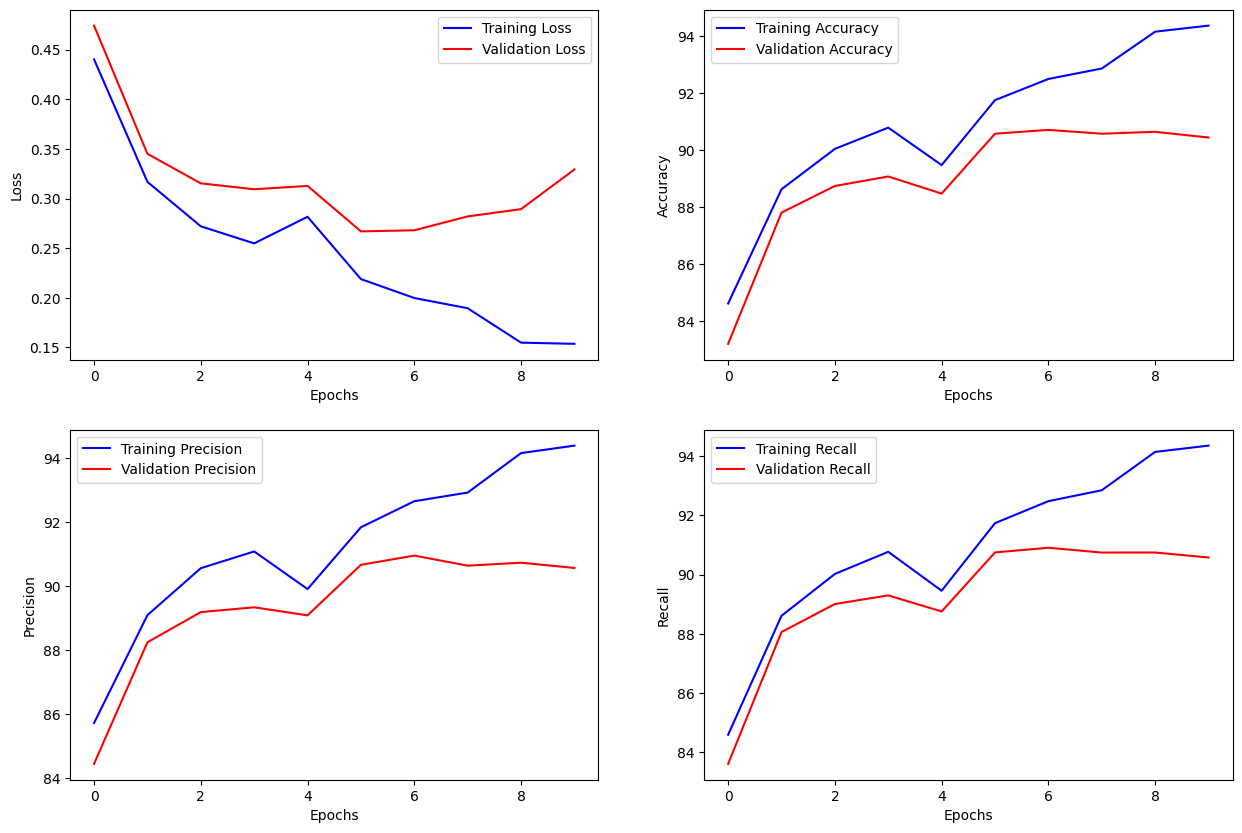

Valid Loss: 0.32935068766276043
Valid Accuracy: 90.43333333333334
Valid Precision: 90.57326824745226
Valid Recall: 90.57594258692903


In [50]:
from torch.utils.data import DataLoader
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Precision, Recall, Loss
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=64)
valid_loader = DataLoader(valid_set, batch_size=64)

metrics = {
    "accuracy": Accuracy(),
    "precision": Precision(average=True),
    "recall": Recall(average=True),
    "loss": Loss(criterion)
}

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

trainer = create_supervised_trainer(model, optimizer, criterion, device)

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_train_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_valid_results, label="Valid")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, print_lr)


train_history = {'accuracy': [], 'precision': [], 'recall': [], 'loss': []}
valid_history = {'accuracy': [], 'precision': [], 'recall': [], 'loss': []}
trainer.run(train_loader, 10)
show_charts()

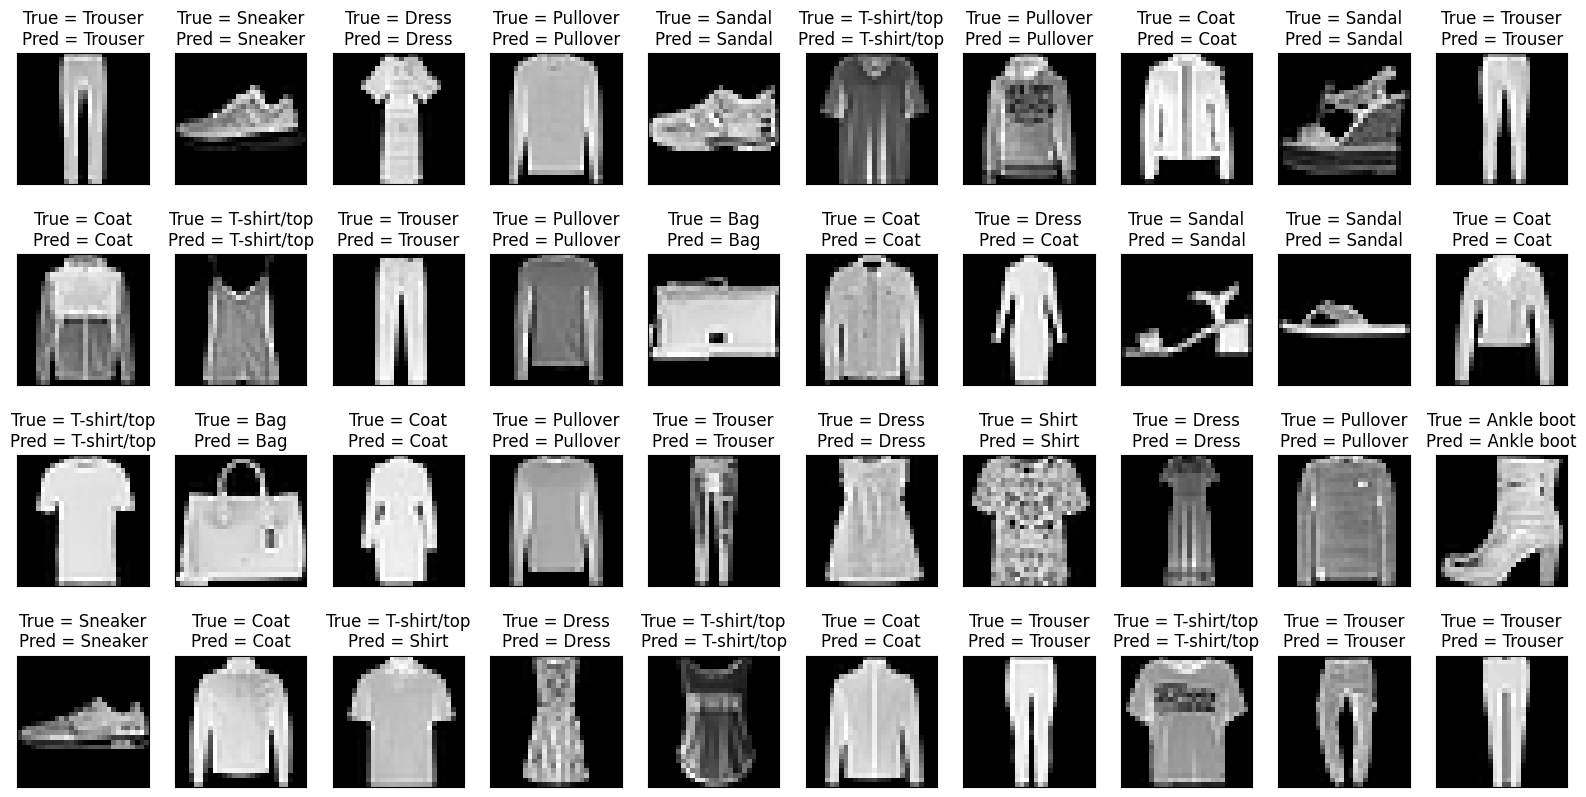

In [52]:
model.eval()

plt.figure(figsize=(20,10))

for i in range(40):
    x, y_true = valid_set[i]
    y_pred = torch.argmax(model(x.unsqueeze(0).to(device)))
    plt.subplot(4, 10, i + 1)
    plt.imshow(x.permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'True = {fashion_names[y_true]}\nPred = {fashion_names[y_pred]}')

plt.show()

Результаты получились почти как в первой задаче, нужно сделать больше эпох. Также видим, что на некоторых эпохах падает accuracy. Получилось: loss = 0.32935068766276043, accuracy = 90.43333333333334